# Experiments for the Eikonal equation in a d-dimensional ball with different sampling distributions

In [20]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_disc import plot_2d_proj_disc
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD
from PointSampling.Ball import data_gen_ball, data_gen_ball_unif
from NeuralNetworks.NNs import FCFF_3L,FCFF_4L

#Right-hand-side of the PDE
def f(X):    
    return 1

#Boundary condition
def g(X):    
    return 0


training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,

    'f': f,
    'g': g,
    'c': None,
    
    'beta': 0.,  ## parameter for the +u_i term
    
    'lambda': 1. #weight parameter for the boundary loss
    }

In [21]:
# Dimension of the d-dimensional ball for each experiment
dim_list = 6*[10]
# Architecture in each experiment
arch_list = 2*[[40,30], 
               [40,30,20], 
               [40,30,20]]
# Sampling distribution: 0 for uniform distribution and 1 for radially uniform distribution
distr_list = 3*[0] + 3*[1]


n_experiments = len(dim_list)
radii = [6., 0.]

# Parameters for each experiment
delta_list = [[.7, .3, .1, .01]]*n_experiments
alpha_list = [[2.5, 2., 1., 0.]]*n_experiments
rounds = len(delta_list[0])

N_col_list = [[200]*rounds]*n_experiments
N_b_list = [[80]*rounds]*n_experiments


num_iterations_list = 2*[[3000, 3000, 3000, 3000],
                       [3000, 3000, 3000, 3000],
                       [3000, 5000, 8000, 12000]] 

100%|██████████| 3000/3000 [00:08<00:00, 343.20it/s]


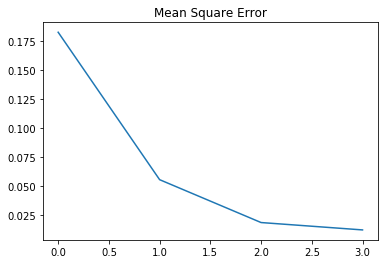

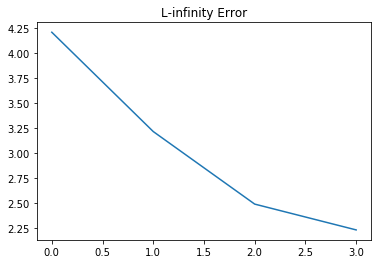

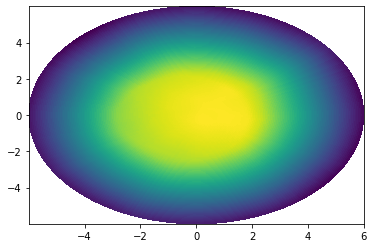

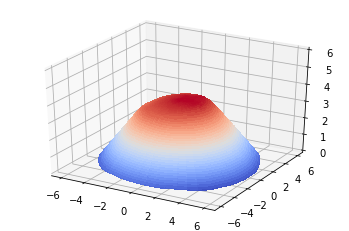

100%|██████████| 3000/3000 [00:10<00:00, 285.11it/s]


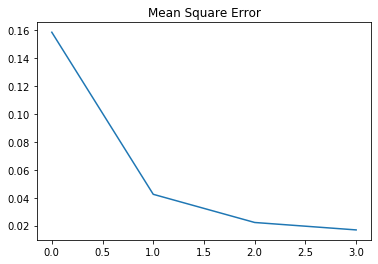

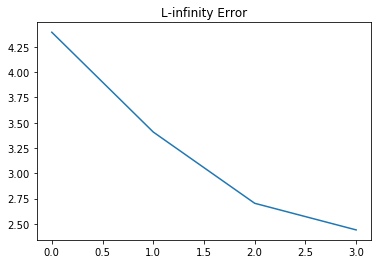

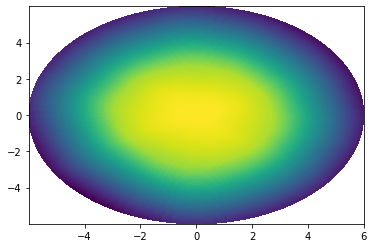

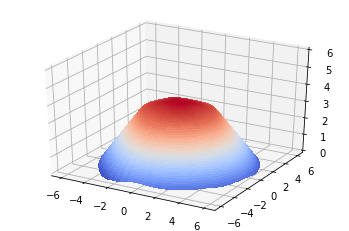

100%|██████████| 12000/12000 [00:40<00:00, 299.73it/s]


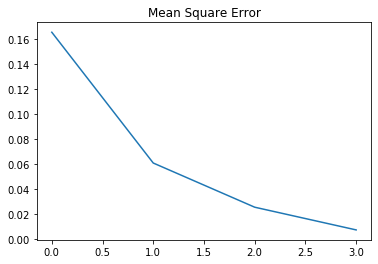

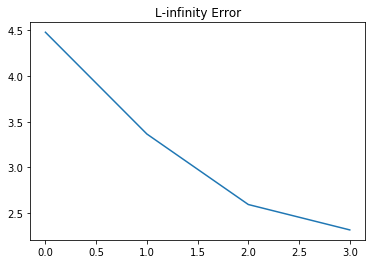

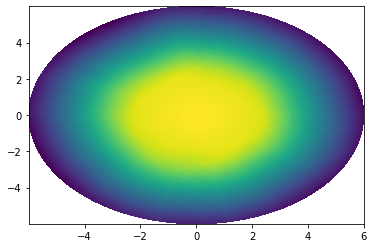

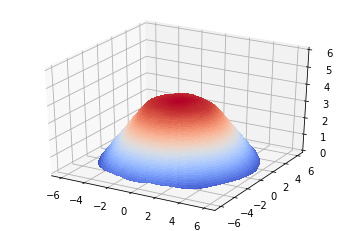

100%|██████████| 3000/3000 [00:09<00:00, 325.89it/s]


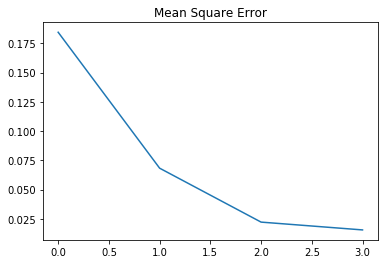

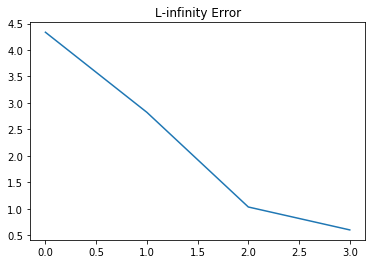

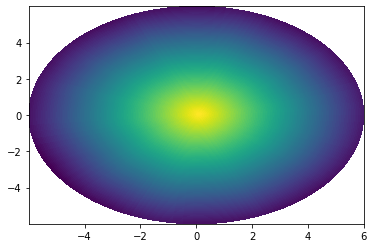

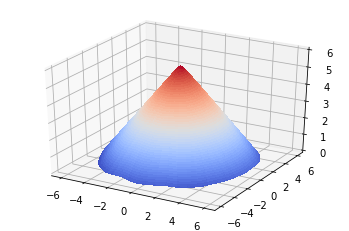

100%|██████████| 3000/3000 [00:11<00:00, 271.47it/s]


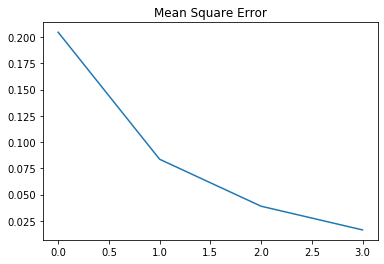

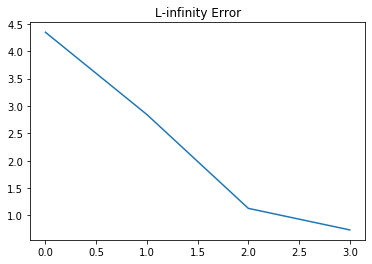

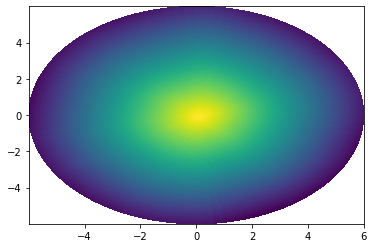

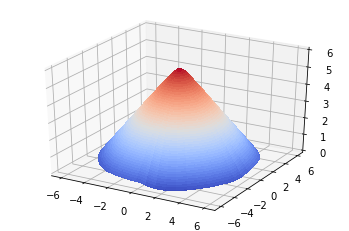

100%|██████████| 12000/12000 [00:36<00:00, 331.90it/s]


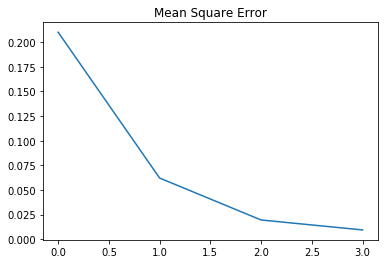

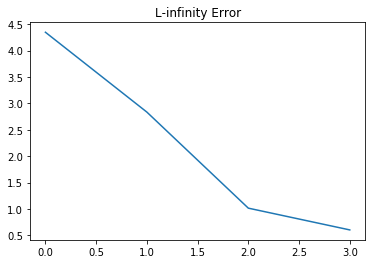

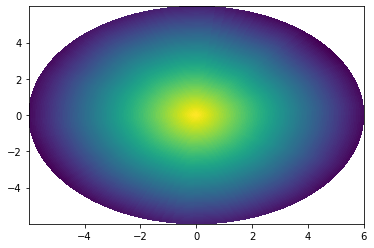

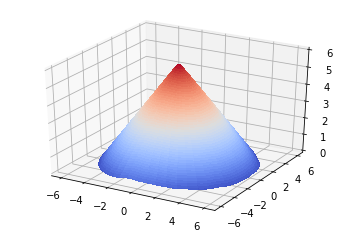

In [22]:
from Training.training import train
from error_test.disc_error import error_ball

MSE_history = torch.zeros([n_experiments, rounds])
L_inf_error_history = torch.zeros([n_experiments, rounds])
run_times = torch.zeros([n_experiments])

# For reproducibility
torch.manual_seed(0)

for j in range(n_experiments):
    
    if distr_list[j] == 0:
        domain = data_gen_ball_unif(radii, dim_list[j])
    elif distr_list[j] == 1:
        domain = data_gen_ball(radii, dim_list[j])
    else:
        domain == None
        
    if len(arch_list[j]) == 2:        
        NN = FCFF_3L([dim_list[j]] + arch_list[j])
    else:
        NN = FCFF_4L([dim_list[j]] + arch_list[j])
        
    training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, momentum = .2)
    
    time = 0.
    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[j][i]
        training_params['delta'] = delta_list[j][i]
        
        training_params['n_coloc_points'] = N_col_list[j][i]
        training_params['n_boundary_points'] = N_b_list[j][i]
        training_params['num_iterations'] = num_iterations_list[j][i]
        
        t0 = t()
        total_loss, PDE_loss, boundary_loss = train(NN, domain, training_params)
        time += t() - t0
        
        MC_points = int(1e6) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN, max(radii), MC_points)
        
        MSE_history[j,i] = MSE
        L_inf_error_history[j,i] = L_inf
    
    run_times[j] = time
    
    plt.plot(MSE_history[j])
    plt.title('Mean Square Error')
    plt.show()
    
    plt.plot(L_inf_error_history[j])
    plt.title('L-infinity Error')
    plt.show()
    
    X_axis = 0
    Y_axis = 1

    n_theta = 100
    n_r = 100
    plot_2d_proj_disc(X_axis, Y_axis, NN, n_theta, n_r, radii)

In [23]:
import pandas as pd
import numpy as np

distr_list_tab = []

for i in range(len(distr_list)):
    if distr_list[i]==0:
        distr_list_tab.append('Unif.')
    elif distr_list[i]==1:
        distr_list_tab.append('Rad.')
    

training_features = pd.DataFrame({'Dimension': dim_list,
                               'Distribution': distr_list_tab,
                               'Architecture': arch_list,
                               'delta': delta_list,
                               'alpha': alpha_list,
                               'N': N_col_list,
                               'N_b': N_b_list,
                               'Iterations': num_iterations_list})

run_T = pd.DataFrame({'Runtime (s)': np.array(run_times)}).astype('int')

results_MSE = pd.DataFrame(np.array(MSE_history))
results_Linf = pd.DataFrame(np.array(L_inf_error_history))


display('Mean Square Error', training_features.join(results_MSE).join(run_T).transpose())
display('L-infinity Error', training_features.join(results_Linf).join(run_T).transpose())

# One table
MSE = np.expand_dims(np.array(MSE_history[:,-1]), axis = 1)
L_inf_error = np.expand_dims(np.array(L_inf_error_history[:,-1]), axis = 1)
errors = np.concatenate((MSE, L_inf_error), axis = 1)
results = pd.DataFrame(errors,  columns = ['MSE', 'L_inf'])

display(training_features.join(results).join(run_T).transpose())

'Mean Square Error'

,0,1,2,3,4,5
Dimension,10,10,10,10,10,10
Distribution,Unif.,Unif.,Unif.,Rad.,Rad.,Rad.
Architecture,"[40, 30]","[40, 30, 20]","[40, 30, 20]","[40, 30]","[40, 30, 20]","[40, 30, 20]"
delta,"[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]"
alpha,"[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 5000, 8000, 12000]","[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 5000, 8000, 12000]"
0,0.182274,0.158724,0.165193,0.184367,0.204599,0.210101
1,0.055712,0.042469,0.060549,0.068327,0.083618,0.062154


'L-infinity Error'

,0,1,2,3,4,5
Dimension,10,10,10,10,10,10
Distribution,Unif.,Unif.,Unif.,Rad.,Rad.,Rad.
Architecture,"[40, 30]","[40, 30, 20]","[40, 30, 20]","[40, 30]","[40, 30, 20]","[40, 30, 20]"
delta,"[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]"
alpha,"[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 5000, 8000, 12000]","[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 5000, 8000, 12000]"
0,4.2085,4.393681,4.478034,4.335979,4.34682,4.345984
1,3.213369,3.407615,3.366061,2.822011,2.843568,2.834341


,0,1,2,3,4,5
Dimension,10,10,10,10,10,10
Distribution,Unif.,Unif.,Unif.,Rad.,Rad.,Rad.
Architecture,"[40, 30]","[40, 30, 20]","[40, 30, 20]","[40, 30]","[40, 30, 20]","[40, 30, 20]"
delta,"[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]","[0.7, 0.3, 0.1, 0.01]"
alpha,"[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]","[2.5, 2.0, 1.0, 0.0]"
N,"[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]","[200, 200, 200, 200]"
N_b,"[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]","[80, 80, 80, 80]"
Iterations,"[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 5000, 8000, 12000]","[3000, 3000, 3000, 3000]","[3000, 3000, 3000, 3000]","[3000, 5000, 8000, 12000]"
MSE,0.012584,0.016928,0.007021,0.015622,0.016313,0.009513
L_inf,2.227512,2.439947,2.317906,0.598769,0.735229,0.604165


In [24]:
display(training_features.join(results_MSE).join(run_T).to_latex())

display(training_features.join(results_Linf).join(run_T).to_latex())

display(training_features.join(results).join(run_T).transpose().to_latex())

'\\begin{tabular}{lrlllllllrrrrr}\n\\toprule\n & Dimension & Distribution & Architecture & delta & alpha & N & N_b & Iterations & 0 & 1 & 2 & 3 & Runtime (s) \\\\\n\\midrule\n0 & 10 & Unif. & [40, 30] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 0.182274 & 0.055712 & 0.018912 & 0.012584 & 34 \\\\\n1 & 10 & Unif. & [40, 30, 20] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 0.158724 & 0.042469 & 0.022261 & 0.016928 & 39 \\\\\n2 & 10 & Unif. & [40, 30, 20] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 5000, 8000, 12000] & 0.165193 & 0.060549 & 0.025198 & 0.007021 & 93 \\\\\n3 & 10 & Rad. & [40, 30] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 0.184367 & 0.068327 & 0.022289 & 0.015622 & 35 \\\\\n4 & 10 & Rad. & [40, 30, 20] 

'\\begin{tabular}{lrlllllllrrrrr}\n\\toprule\n & Dimension & Distribution & Architecture & delta & alpha & N & N_b & Iterations & 0 & 1 & 2 & 3 & Runtime (s) \\\\\n\\midrule\n0 & 10 & Unif. & [40, 30] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 4.208500 & 3.213369 & 2.486176 & 2.227512 & 34 \\\\\n1 & 10 & Unif. & [40, 30, 20] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 4.393681 & 3.407615 & 2.703154 & 2.439947 & 39 \\\\\n2 & 10 & Unif. & [40, 30, 20] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 5000, 8000, 12000] & 4.478034 & 3.366061 & 2.595423 & 2.317906 & 93 \\\\\n3 & 10 & Rad. & [40, 30] & [0.7, 0.3, 0.1, 0.01] & [2.5, 2.0, 1.0, 0.0] & [200, 200, 200, 200] & [80, 80, 80, 80] & [3000, 3000, 3000, 3000] & 4.335979 & 2.822011 & 1.032146 & 0.598769 & 35 \\\\\n4 & 10 & Rad. & [40, 30, 20] 

'\\begin{tabular}{lllllll}\n\\toprule\n & 0 & 1 & 2 & 3 & 4 & 5 \\\\\n\\midrule\nDimension & 10 & 10 & 10 & 10 & 10 & 10 \\\\\nDistribution & Unif. & Unif. & Unif. & Rad. & Rad. & Rad. \\\\\nArchitecture & [40, 30] & [40, 30, 20] & [40, 30, 20] & [40, 30] & [40, 30, 20] & [40, 30, 20] \\\\\ndelta & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] & [0.7, 0.3, 0.1, 0.01] \\\\\nalpha & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] & [2.5, 2.0, 1.0, 0.0] \\\\\nN & [200, 200, 200, 200] & [200, 200, 200, 200] & [200, 200, 200, 200] & [200, 200, 200, 200] & [200, 200, 200, 200] & [200, 200, 200, 200] \\\\\nN_b & [80, 80, 80, 80] & [80, 80, 80, 80] & [80, 80, 80, 80] & [80, 80, 80, 80] & [80, 80, 80, 80] & [80, 80, 80, 80] \\\\\nIterations & [3000, 3000, 3000, 3000] & [3000, 3000, 3000, 3000] & [3000, 5000, 8000, 12000] & [3000, 3000, 3000, 3000] & [3000, 300

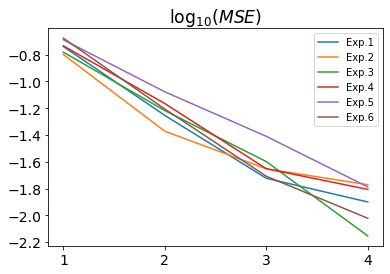

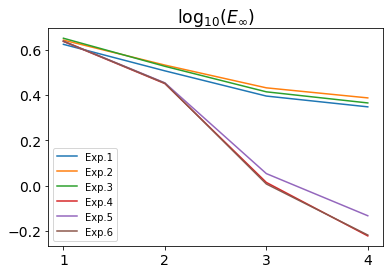

In [25]:
from mpl_toolkits.axes_grid1 import host_subplot

ax = host_subplot(111)
for i in range(MSE_history.shape[0]):
    x = np.arange(rounds) + 1
    MSE_log10 =torch.log10(MSE_history[i])
    
    text = 'Exp.' + str(i+1)
    
    ax.plot(x, MSE_log10, label = text)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.legend()
plt.show()

ax = host_subplot(111)
for i in range(L_inf_error_history.shape[0]):
    L_inf_log10 = torch.log10(L_inf_error_history[i])
    
    text = 'Exp.' + str(i+1)
    
    ax.plot(x, L_inf_log10, label = text)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.legend()
plt.show()